# Part 1. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('../Take_Home_Challenge/logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


I will now try to aggregate the above login_time column converting it into 15 min time period by resampling it.

In [3]:
df_login_count = df.resample('15min', on='login_time').count()

#cleaning up df
df_login_count.index.name = "indx"
df_login_count.reset_index(inplace=True)
df_login_count.rename({"login_time":"logins"}, axis=1, inplace=True)

#show
df_login_count.head()

,indx,logins
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


We can also see on what days these logins occur by incorportaing date-time module and extracting the day of the week as well as when the login occured, for example in day or at night(we can set that to AM or PM).

In [4]:
from datetime import datetime as dt

df_login_count['hour'] = df_login_count['indx'].dt.hour
df_login_count['day'] = df_login_count['indx'].dt.day_name()

In [5]:
df_login_count.head()

,indx,logins,hour,day
0,1970-01-01 20:00:00,2,20,Thursday
1,1970-01-01 20:15:00,6,20,Thursday
2,1970-01-01 20:30:00,9,20,Thursday
3,1970-01-01 20:45:00,7,20,Thursday
4,1970-01-01 21:00:00,1,21,Thursday


In [6]:
# Now let us extract AM or PM from the dataframe

am_pm = lambda x: "AM" if x in range(0,12) else "PM"
df_login_count["AM-PM"] = df_login_count["hour"].apply(am_pm)

df_login_count.head()

,indx,logins,hour,day,AM-PM
0,1970-01-01 20:00:00,2,20,Thursday,PM
1,1970-01-01 20:15:00,6,20,Thursday,PM
2,1970-01-01 20:30:00,9,20,Thursday,PM
3,1970-01-01 20:45:00,7,20,Thursday,PM
4,1970-01-01 21:00:00,1,21,Thursday,PM


Now that we obtained the day or night column, we can also check to see the sum of the aggregations of the logins on a particular day of the week. Let us see that

In [7]:
df_daily = df_login_count.groupby('day')[['logins']].sum().sort_values(by='logins',ascending=False)
df_daily

,logins
day,
Saturday,19377
Sunday,18167
Friday,15208
Thursday,11960
Wednesday,10339
Tuesday,9268
Monday,8823


Now, we can check the average of daily login in a week by the users. This helps us to determine how many times users logs in in a given period of the week.

In [8]:
df_daily['daily_avg'] = df_login_count.groupby('day')[['logins']].mean().sort_values(by='logins',ascending=False)
df_daily

,logins,daily_avg
day,,
Saturday,19377,13.456250
Sunday,18167,12.615972
Friday,15208,10.561111
Thursday,11960,8.794118
Wednesday,10339,7.692708
Tuesday,9268,6.895833
Monday,8823,6.213380


It looks like Saturday and Sunday has more average logins, which makes sense, since it is a weekend. Now let us try to extract a bit more by comparing the daily logins split between day and night, of when the user login activity is more or when it is less. This may require multi-hierarchial grouping by.

In [9]:
df_display = df_login_count.groupby(['day', 'AM-PM'])[['logins']].sum().sort_values(by='day',ascending=False)
df_display['daily_avg'] = df_login_count.groupby(['day', 'AM-PM'])[['logins']].mean().sort_values(by='day',ascending=False)
df_display

logins  daily_avg
day       AM-PM                   
Wednesday AM       4570   6.800595
          PM       5769   8.584821
Tuesday   AM       3961   5.894345
          PM       5307   7.897321
Thursday  AM       5153   7.668155
          PM       6807   9.893895
Sunday    AM      10351  14.376389
          PM       7816  10.855556
Saturday  AM      10217  14.190278
          PM       9160  12.722222
Monday    AM       3905   5.423611
          PM       4918   7.025714
Friday    AM       5924   8.227778
          PM       9284  12.894444

Let us try to plot some average daily logins over the entire course of the week

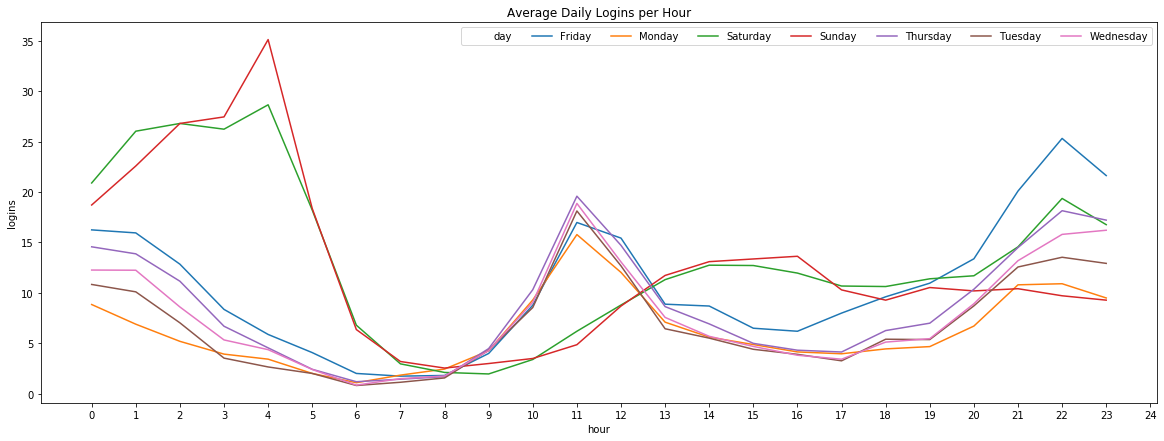

In [10]:
#getting average daily logins per hour
df_total = df_login_count.groupby(["hour", "day"]).mean().reset_index()

#plotting df
fig, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="hour", y="logins", data=df_total, hue="day")
ax.legend(loc="upper right", ncol=8)
ax.set(title="Average Daily Logins per Hour")
plt.xticks(range(0,25))

#display plot
plt.show()

Text(0, 0.5, 'Total number of login counts')

<Figure size 1224x288 with 0 Axes>

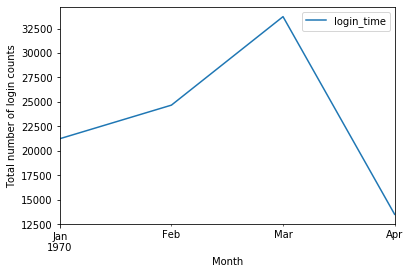

In [11]:
df = df.set_index(pd.to_datetime(df['login_time']))
df_sampled = df.resample('M').count()
plt.figure(figsize=(17,4)) # The entire data set
df_sampled.plot()
plt.xlabel('Month')
plt.ylabel('Total number of login counts')

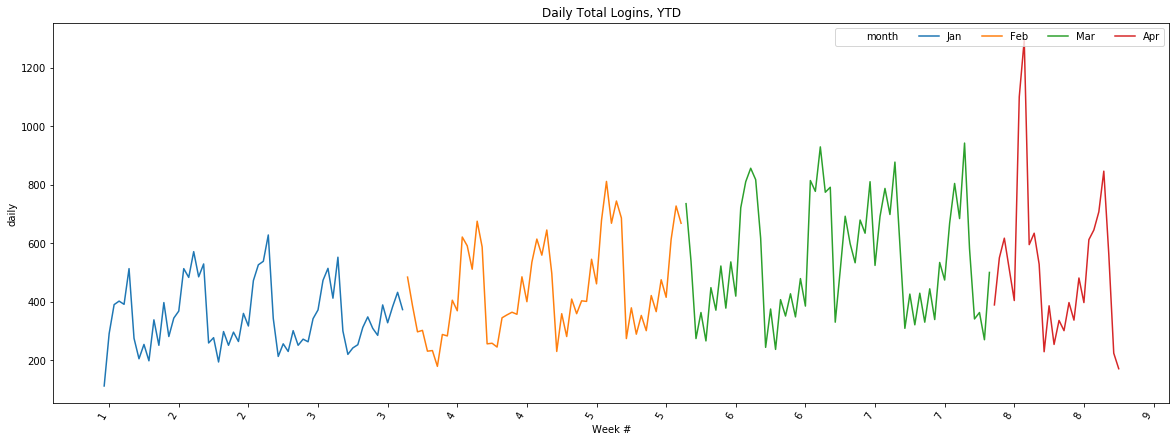

In [12]:
import matplotlib.dates as mdates

#resampling df to daily intervals
df_daily = df.resample("12H", on="login_time").count()

#cleaning up df
df_daily.index.name = "indx"
df_daily.reset_index(inplace=True)
df_daily.rename({"login_time":"daily"}, axis=1, inplace=True)

#extracting months
df_daily["month"] = df_daily["indx"].dt.month
df_daily["month"] = df_daily["month"].map({1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr"})

#plotting df
f, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="indx", y="daily", data=df_daily, hue="month")
ax.legend(loc="upper right", ncol=5)
ax.set(title="Daily Total Logins, YTD", xlabel="Week #")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.set_xticklabels(labels=df_daily["indx"].dt.day, rotation=60, ha="right")

#display plot
plt.show()

We see some interesting patterns in our above graph. In April, there is a huge spike in number of login counts, which means that it is a peak time in that month. Also, the logins are gradually increasing.

# Part 2: Experiment and Metrics

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

Solution: For encouraging both driver partners to work effictively in this proposed experiment, I would suggest that the driver partners of both Metropolis and Gotham be available in both cities during the weekend. Because in the weekdays, it sure would be a bit difficult to manage the hours in a shift of the drivers, since they might not opt to work more than 12 hours a day. Also, during weekends, the shift can be flexible, as there will be more active work, though the drivers would be more reasonable to drop off and pick up customers even though there are toll charges, which will be reimbursed.

Another metric will be to check how the average wait times in either city changes prior and post the experiment, along with the average price during busy hours. 

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the observation

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Solution: Firstly, I would track/keep an eye on all of the drivers movements like where/which city they might be located in. This can be in weekdays or weekends. The next step I will take would be to let all the drivers know about this new toll policy on how it got changed. Once informed, I would then try to track their rides and movements on where the drivers are, i.e, in which cities they now tend to be in. A prominient thing we can discover is how many times the drivers keep travelling in between the cities and how many times the location changes. There are a few statistical tests which come in handy to use for this type of problem. The one I would use is a paired t-test. Basically, t-test is useful in calculating the means. Here I can use a paired t-test for comparing the mean trips of the drivers before and after the experiment. Number of trips also should be take into account just to see how significact the changes are. If the effect size level of the t-test is > 0.2 as Cohen suggested, then there is a difference in change of the method/experiment proposed, which is considerable. Then the experiment can be employed for the future as well, if there is good amount of expenses/investment coming in.

# 3. Predictive Modeling

Let us now open the file needed for predictive modelling. Let's do some analysis first before proceeding to the ML part.

In [14]:
import json

with open('../Take_Home_Challenge/ultimate_data_challenge.json', 'r') as f:
    datastore = json.load(f)

df = pd.DataFrame(datastore)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Let us convert the signup_date and last_trip_date columns from string to datetime object so we can work with it as datetime

In [16]:
sub_df= df.copy()
sub_df['signup_date'] = pd.to_datetime(sub_df['signup_date'])
sub_df['last_trip_date'] = pd.to_datetime(sub_df['last_trip_date'])

In [17]:
sub_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


We have now see if a user is active, only if he/she has taken a ride in the first 30 days that they signed up. Below logic will be created for that purpose.

In [18]:
len(sub_df)

50000

In [19]:
# a for loop to create active users or not after 6 months and if they have taken a trip the preceeding 30 days

active_users = []
for i in range(len(sub_df)):
    sign_up = pd.Timestamp(sub_df['signup_date'][i]) #get start date
    future_date = sign_up + pd.Timedelta('181D') #6 months later
    preceeding_thirty = future_date - pd.Timedelta('30D') #set point 30 days prior
    if preceeding_thirty <= pd.Timestamp(sub_df['last_trip_date'][i]) <= future_date:
        active_users.append([1]) # now that the active condition has been met, set active user to 1
    else:
        active_users.append([0])

In [20]:
active_df = pd.DataFrame(active_users, columns=['active_users'])
active_df.head()

,active_users
0,0
1,0
2,0
3,1
4,0


In [21]:
active_df['active_users'].value_counts()

0    37802
1    12198
Name: active_users, dtype: int64

From the above count, looks like almost 12000 people were active from the date preceeding 30 days after six months, which I have taken into account. Now I will use seaborn countplot to plot the obtained active vs not active users

[Text(0, 0, 'Inactive Users'), Text(0, 0, 'Active Users')]

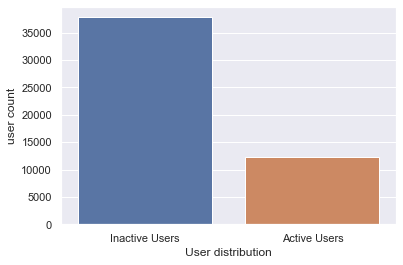

In [22]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="active_users", data=active_df)
plt.xlabel('User distribution')
plt.ylabel('user count')
ax.set_xticklabels(["Inactive Users", "Active Users"])

Now, let me quickly take a look at the correlation between independent variables and also with the target variable, active users. We can plot regression plots and see how strong or weak the correlation is

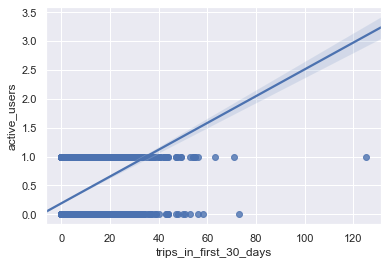

In [23]:
ax = sns.regplot(x=sub_df['trips_in_first_30_days'], y=active_df['active_users'], fit_reg=True)

Looks like there is a strong correlation between those 2 variables, even though there is an outlier in the data which we can see.

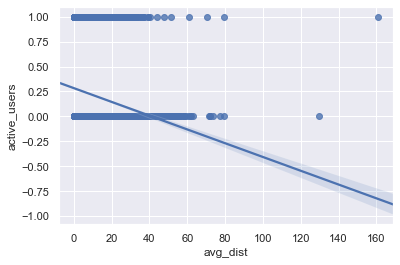

In [24]:
ax = sns.regplot(x=sub_df['avg_dist'], y=active_df['active_users'], fit_reg=True)

As we can see, there is a strong negative correlation between the above variables, since as the average distance increases, the active users tends to decrease. THis may be true in some cases where users wants to travel for long distances.

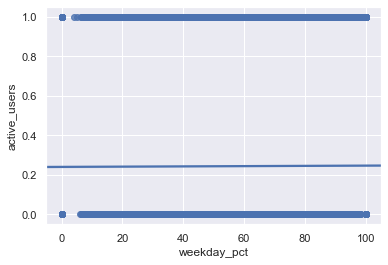

In [25]:
ax = sns.regplot(x=sub_df['weekday_pct'], y=active_df['active_users'], fit_reg=True)

There seems to be no correlation at all for the variables. So i would not include these for my model later.

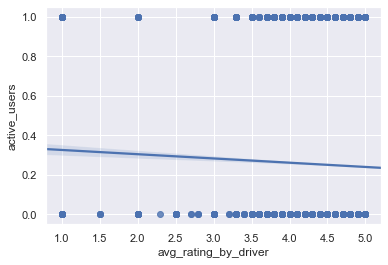

In [26]:
ax = sns.regplot(x=sub_df['avg_rating_by_driver'], y=active_df['active_users'], fit_reg=True)

Now let me try to finally include the required features needed for my model later and do a bit more analysis before proceeding further in building one.

In [27]:
# combining the active_users df and sub_df to include the active users as well.

final_df = pd.concat([sub_df, active_df], axis=1)
final_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_users
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [28]:
final_df = final_df.drop(['avg_rating_of_driver', 'avg_surge','surge_pct','last_trip_date','signup_date','weekday_pct'], axis = 1)

In [29]:
final_df.head()

,city,trips_in_first_30_days,phone,ultimate_black_user,avg_dist,avg_rating_by_driver,active_users
0,King's Landing,4,iPhone,True,3.67,5.0,0
1,Astapor,0,Android,False,8.26,5.0,0
2,Astapor,3,iPhone,False,0.77,5.0,0
3,King's Landing,9,iPhone,True,2.36,4.9,1
4,Winterfell,14,Android,False,3.13,4.9,0


In [30]:
print(final_df.isna().any())

city                      False
trips_in_first_30_days    False
phone                      True
ultimate_black_user       False
avg_dist                  False
avg_rating_by_driver       True
active_users              False
dtype: bool


Let us work on filling the missing data with the mean since it makes more sense to fill out with average rating.

In [31]:
import numpy as np

#replace avg_rating_by_driver NaNs with mean
mean = final_df["avg_rating_by_driver"].mean()
rating = lambda x: mean if np.isnan(x) else x
final_df["avg_rating_by_driver"] = final_df["avg_rating_by_driver"].apply(rating)

In [32]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
phone                     49604 non-null object
ultimate_black_user       50000 non-null bool
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
active_users              50000 non-null int64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 2.3+ MB


In [33]:
final_df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [34]:
# working on filling out missing data for the phone feature. Classifying the NaN data phone as Other since that phone might
#not be recognized as android or iPhone

other = lambda x: "Other" if type(x) != str else x
final_df["phone"] = final_df["phone"].apply(other)

print(final_df["phone"].unique())

['iPhone' 'Android' 'Other']


We can now check how many active vs inactive users uses iphone or Android on the whole. We can use crosstab to do this.

In [35]:
# Table of phone type vs active
phone_active = pd.crosstab(index=final_df["active_users"], 
                            columns=final_df["phone"],
                             margins=True)   # Include row and column totals

phone_active.columns = ["Android", "other","iPhone", "rowtotal"]
phone_active.index= ["Not Active","Active","coltotal"]

phone_df = pd.DataFrame(phone_active)
phone_df

,Android,other,iPhone,rowtotal
Not Active,13096,312,24394,37802
Active,1926,84,10188,12198
coltotal,15022,396,34582,50000


We can also check how users are active or not in different cities. That way we would be able to know what the statistics might be on how the activityof the users are.

In [36]:
# Table of city type vs active/inactive users

city_users_active = pd.crosstab(index=final_df["active_users"], 
                            columns=final_df["city"],
                             margins=True)   # Include row and column totals

city_users_active.columns = ["Astapor","King's Landing","Winterfell", "rowtotal"]
city_users_active.index= ["Not Active","Active","coltotal"]

city_df = pd.DataFrame(city_users_active)
city_df

,Astapor,King's Landing,Winterfell,rowtotal
Not Active,13838,6099,17865,37802
Active,2696,4031,5471,12198
coltotal,16534,10130,23336,50000


## Preparing data for modeling

In [37]:
# Let us check our dataframe once

final_df.head(2)

,city,trips_in_first_30_days,phone,ultimate_black_user,avg_dist,avg_rating_by_driver,active_users
0,King's Landing,4,iPhone,True,3.67,5.0,0
1,Astapor,0,Android,False,8.26,5.0,0


In [38]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
phone                     50000 non-null object
ultimate_black_user       50000 non-null bool
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
active_users              50000 non-null int64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 2.3+ MB


There are numerical as well as categorical columns in the dataset. So let us convert all the categorical features into numerical, so that it would be easy for our model to work with the data.

In [39]:
#splitting into features and target
y = final_df['active_users']
X = final_df[['avg_dist', 'avg_rating_by_driver','trips_in_first_30_days', 'city', 'phone','ultimate_black_user']]

## Model Prediction

In [40]:
# SPlitting the dataset to training and testing sets
 
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12, stratify=y)

In [41]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(30000, 6)
(20000, 6)
30000
20000


Here, I used Column Transformer, which basically applies transformers to columns of an array or pandas DataFrame. Here it combines oneHotEncoding and LabelEncoding at a time. I will use that to convert the categorical features.
ALso, The numeric_transformer simply scales the features so the magnitudes are relative. The categorical_transformer performs one-hot encoding on the categorical columns.

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#pipeline for numeric features
numeric_features = ["avg_dist", "avg_rating_by_driver", "trips_in_first_30_days"]
numeric_scaler = [("scaler", StandardScaler())]
numeric_transformer = Pipeline(numeric_scaler)

#pipeline for categorical features
categorical_features = ["city", "phone", "ultimate_black_user"]
categorical_encoding = [("encoder", OneHotEncoder())]
categorical_transformer = Pipeline(categorical_encoding)

#preprocessing the above two using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features), \
                  ("cat", categorical_transformer, categorical_features)])

In [43]:
%%time

#incorporating the Logistic Regression Classifier model

pipeline = Pipeline(steps=[("pre", preprocessor), \
                           ("rfr", RandomForestClassifier(random_state = 12))])

params = {"rfr__n_estimators" : [100,150,300],
          "rfr__max_depth" : [8, 12, 15],
          "rfr__bootstrap": [True]}

cv = GridSearchCV(pipeline, param_grid=params, cv=5)
cv.fit(X_train, y_train)

Wall time: 1min 38s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pre',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                 

In [44]:
print(f"Taining score: {cv.best_score_*100:.2f}%")

Taining score: 78.44%


In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_pred = cv.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test,y_pred)*100:.2f}%")
print('Confusion matrix:\n',confusion_matrix(y_test,y_pred))
print('Classification report:\n',classification_report(y_test,y_pred))

Accuracy: 78.33%
Confusion matrix:
 [[14078  1043]
 [ 3290  1589]]
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87     15121
           1       0.60      0.33      0.42      4879

    accuracy                           0.78     20000
   macro avg       0.71      0.63      0.64     20000
weighted avg       0.76      0.78      0.76     20000



## Model Evaluation

Let us plot a AUC-ROC curve to compute Area Under the Curve (ROC AUC) from prediction scores. Tis is an important graph to see how well our model performed, and what can be deduced from this.

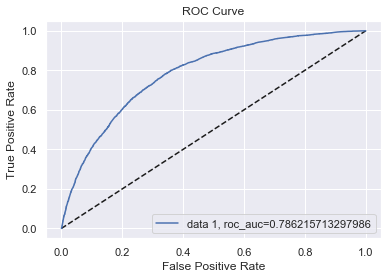

In [46]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="data 1, roc_auc="+str(roc_auc))
plt.legend(loc=4)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Important features in Rider retention after 6 months

In [47]:
# important features in form of ndarray.

pipeline.fit(X_train, y_train)

#https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
imp_features = pipeline.named_steps['rfr'].feature_importances_[:6]

print(imp_features)

C:\Users\Ravi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.6394914  0.15476602 0.11408208 0.01037978 0.02199663 0.00784248]


In [48]:
#create a feature list from the original dataset (list of columns)
feature_list = list(X.columns)

#create a list of tuples
feature_importance= sorted(zip(imp_features, feature_list), reverse=True)

#create two lists from the previous list of tuples
df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df['importance'])
feature= list(df['feature'])

#see df
print(df)

   importance                 feature
0    0.639491                avg_dist
1    0.154766    avg_rating_by_driver
2    0.114082  trips_in_first_30_days
3    0.021997                   phone
4    0.010380                    city
5    0.007842     ultimate_black_user


#### Conclusion

As we can see here, the average distance is a key factor, almost around 63% and plays a very important role in determining the riders on how far they reside or how far they travel. If the riders travel locally, then the avg_distance becomes important. 
Apart from this I believe there is also a better app experience for iPhone users, so improving the Android app would likely help. If looking for new users, Astapor is the city to focus on as it had the worst rate. A comparison to King's Landing would be beneficial as those users are very active.